In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import glob
import datetime
from finlab import data
import warnings
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
from equity_plot import equity_plot
import lightgbm as lgb
warnings.filterwarnings("ignore")

## 資料整理

In [2]:
path = 'C:\\Users\\qwtl0\\OneDrive\\文件\\Python\\台股股價資料\\'

In [3]:
label = pd.read_csv(path+'finlab_database.csv')
# label

In [4]:
dataset = pd.read_pickle(path+'台股上市公司資料.pkl')

In [5]:
dataset.columns

Index(['date', '股票代碼', '自營商買進股數_自行買賣', '自營商買進股數_避險', '自營商買賣超股數_自行買賣',
       '自營商買賣超股數_避險', '自營商賣出股數_自行買賣', '自營商賣出股數_避險', '投信買進股數', '投信買賣超股數',
       '投信賣出股數', '當日沖銷交易成交股數', '當日沖銷交易買進成交金額', '當日沖銷交易賣出成交金額', '資券互抵',
       '融券今日餘額', '融券使用率', '融券前日餘額', '融券限額', '融券現券償還', '融券買進', '融券賣出', '融資今日餘額',
       '融資使用率', '融資前日餘額', '融資限額', '融資現金償還', '融資買進', '融資賣出', '成交股數', '成交金額',
       '成交筆數', '收盤價', '最低價', '最高價', '開盤價', '本益比', '股價淨值比', '殖利率_%', '當日報酬率',
       '昨日跳高價差', '昨日跳低價差', '昨日跳空率', '五日價均線', '五日量均線', '五日價波動', '五日量波動',
       '產業類別_光電業', '產業類別_其他', '產業類別_其他電子業', '產業類別_化學工業', '產業類別_半導體業',
       '產業類別_塑膠工業', '產業類別_建材營造', '產業類別_橡膠工業', '產業類別_水泥工業', '產業類別_汽車工業',
       '產業類別_油電燃氣業', '產業類別_玻璃陶瓷', '產業類別_生技醫療業', '產業類別_紡織纖維', '產業類別_航運業',
       '產業類別_觀光事業', '產業類別_貿易百貨', '產業類別_資訊服務業', '產業類別_通信網路業', '產業類別_造紙工業',
       '產業類別_金融保險業', '產業類別_鋼鐵工業', '產業類別_電器電纜', '產業類別_電子通路業', '產業類別_電子零組件業',
       '產業類別_電機機械', '產業類別_電腦及週邊設備業', '產業類別_食品工業'],
      dtype='object')

In [6]:
dataset['當日報酬led1'] = dataset.groupby('股票代碼')['當日報酬率'].shift(-1)

In [7]:
q33 = dataset['當日報酬led1'].quantile(q = 0.33)
q66 = dataset['當日報酬led1'].quantile(q = 0.66)
q50 = dataset['當日報酬led1'].quantile(q = 0.5)
print('Short : %f , Long : >= %f' %(q33,q66))
print('half : %f' %(q50))

Short : -0.006042 , Long : >= 0.002941
half : 0.000000


In [13]:
dataset['方向'] = np.where(dataset['當日報酬led1']>=0.002298 , 1 ,-1)

In [27]:
dataset['方向'].value_counts()

-1    985070
 1    506772
Name: 方向, dtype: int64

In [122]:
var_list = ['自營商買進股數_自行買賣', '自營商買進股數_避險', '自營商買賣超股數_自行買賣',
       '自營商買賣超股數_避險', '自營商賣出股數_自行買賣', '自營商賣出股數_避險', '投信買進股數', '投信買賣超股數',
       '投信賣出股數', '當日沖銷交易成交股數', '當日沖銷交易買進成交金額', '當日沖銷交易賣出成交金額', '資券互抵',
       '融券今日餘額', '融券使用率', '融券前日餘額', '融券限額', '融券現券償還', '融券買進', '融券賣出', '融資今日餘額',
       '融資使用率', '融資前日餘額', '融資限額', '融資現金償還', '融資買進', '融資賣出', '成交股數', '成交金額',
       '成交筆數' ,'五日量均線', '五日價波動', '五日量波動',
       '昨日跳空率', '產業類別_光電業', '產業類別_其他', '產業類別_其他電子業',
       '產業類別_化學工業', '產業類別_半導體業', '產業類別_塑膠工業', '產業類別_建材營造', '產業類別_橡膠工業',
       '產業類別_水泥工業', '產業類別_汽車工業', '產業類別_油電燃氣業', '產業類別_玻璃陶瓷', '產業類別_生技醫療業',
       '產業類別_紡織纖維', '產業類別_航運業', '產業類別_觀光事業', '產業類別_貿易百貨', '產業類別_資訊服務業',
       '產業類別_通信網路業', '產業類別_造紙工業', '產業類別_金融保險業', '產業類別_鋼鐵工業', '產業類別_電器電纜',
       '產業類別_電子通路業', '產業類別_電子零組件業', '產業類別_電機機械', '產業類別_電腦及週邊設備業', '產業類別_食品工業']

In [16]:
dataset = dataset.set_index('date')

KeyError: "None of ['date'] are in the columns"

## Train

In [123]:
train_date = '2022-01-01'
test_date = '2022-01-10'

trainx = dataset.loc[:train_date,var_list]
trainy = dataset.loc[:train_date,'方向']
testx = dataset.loc[test_date:,var_list]
testy = dataset.loc[test_date:,'方向']

#回測資料
test_data = dataset.loc[test_date:]
train_data = dataset.loc[:train_date]

In [124]:
model = lgb.LGBMClassifier(
                            objective = 'binary',
                            boosting_type='gbdt',
                            num_leaves=31,
                            min_child_samples = 20,
                            max_depth=-1,
                            learning_rate=0.01,
                            n_estimators=400,
                            scale_pos_weight = 2.1,
                            bagging_fraction = 0.7,
                            bagging_freq = 10)
model.fit(trainx,trainy)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMClassifier(bagging_fraction=0.7, bagging_freq=10, learning_rate=0.01,
               n_estimators=400, objective='binary', scale_pos_weight=2.1)

In [125]:
train_pred = model.predict(trainx)
train_pred_pra = model.predict_proba(trainx)

test_pred=model.predict(testx)
test_pred_pra = model.predict_proba(testx)

In [126]:
train_data['pred'] = train_pred
train_data['short_prob'] = pd.DataFrame(train_pred_pra).iloc[:,0].values
train_data['long_prob'] = pd.DataFrame(train_pred_pra).iloc[:,1].values

test_data['pred'] = test_pred
test_data['short_prob'] = pd.DataFrame(test_pred_pra).iloc[:,0].values
test_data['long_prob'] = pd.DataFrame(test_pred_pra).iloc[:,1].values

### Score and Backtest

In [127]:
print("Accuracy on train:\t", metrics.accuracy_score(trainy, train_pred))
print("Precision on train:\t", metrics.precision_score(trainy, train_pred))
print("Recall on train:\t", metrics.recall_score(trainy, train_pred))
print("F1 on train:\t\t", metrics.f1_score(trainy, train_pred))
print('\n')
print("Accuracy on test:\t", metrics.accuracy_score(testy, test_pred))
print("Precision on test:\t", metrics.precision_score(testy, test_pred))
print("Recall on test:\t\t", metrics.recall_score(testy, test_pred))
print("F1 on test:\t\t", metrics.f1_score(testy, test_pred))

Accuracy on train:	 0.44419641571279617
Precision on train:	 0.3687516074991137
Recall on train:	 0.9033897872123023
F1 on train:		 0.5237254877762831


Accuracy on test:	 0.40579769068141164
Precision on test:	 0.3713605319913731
Recall on test:		 0.9298008774890314
F1 on test:		 0.5307432974795312


In [128]:
print('訓練集資料Label : 資料時間(%s - %s)' %(train_data.index.min(),train_data.index.max()))
print(train_data['方向'].value_counts())
print('預測結果')
print(np.unique(train_pred,return_counts = True))
print('\n')

print('測試集資料Label : 資料時間(%s - %s)' %(test_data.index.min(),test_data.index.max()))
print(test_data['方向'].value_counts())
print('預測結果')
print(np.unique(test_pred,return_counts = True))

訓練集資料Label : 資料時間(2016-01-04 00:00:00 - 2021-12-30 00:00:00)
-1    918964
 1    469764
Name: 方向, dtype: int64
預測結果
(array([-1,  1]), array([ 237872, 1150856], dtype=int64))


測試集資料Label : 資料時間(2022-01-10 00:00:00 - 2022-06-20 00:00:00)
-1    62828
 1    35556
Name: 方向, dtype: int64
預測結果
(array([-1,  1]), array([ 9360, 89024], dtype=int64))


In [129]:
#Train
train_bt_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'pred',columns = '股票代碼')
train_long_prob_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'long_prob',columns = '股票代碼')
train_intraday_pivot = train_data.reset_index().pivot_table(index = 'date',values = '當日報酬led1',columns = '股票代碼')
train_volume_pivot = train_data.reset_index().pivot_table(index = 'date',values = '成交股數',columns = '股票代碼')
train_bt_time = train_bt_pivot.index


test_bt_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'pred',columns = '股票代碼')
test_long_prob_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'long_prob',columns = '股票代碼')
test_intraday_pivot = test_data.reset_index().pivot_table(index = 'date',values = '當日報酬led1',columns = '股票代碼')
test_volume_pivot = test_data.reset_index().pivot_table(index = 'date',values = '成交股數',columns = '股票代碼')
test_bt_time = test_bt_pivot.index

<AxesSubplot:title={'center':'當日報酬led1'}, xlabel='[prob_cut]'>

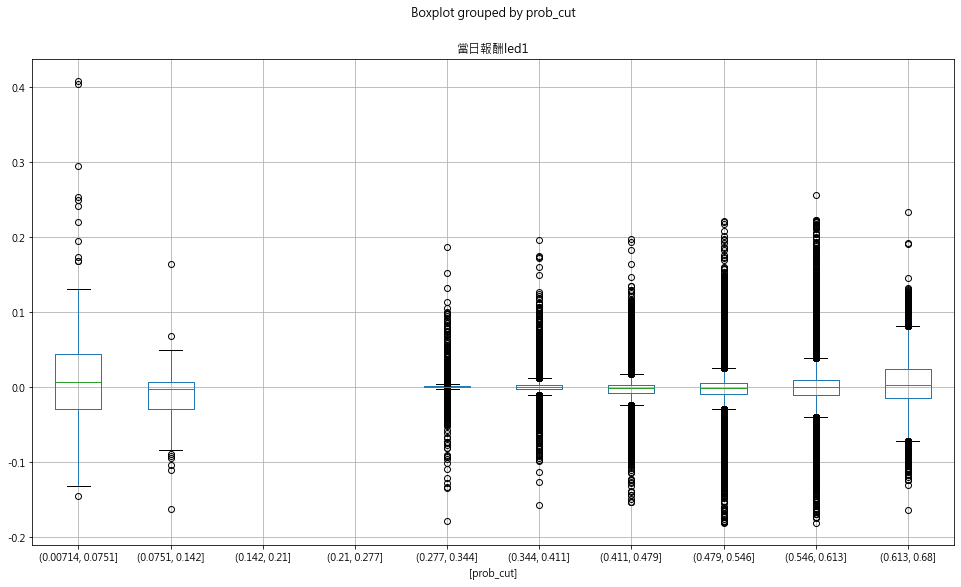

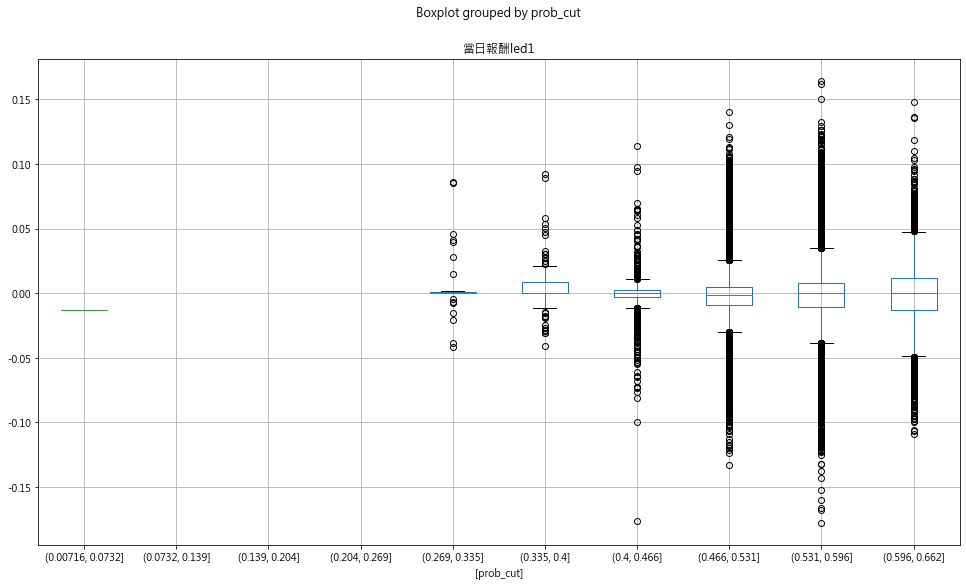

In [130]:
train_data['prob_cut'] = pd.cut(train_data['long_prob'],bins = 10)
test_data['prob_cut'] = pd.cut(test_data['long_prob'],bins = 10)

train_data[['當日報酬led1','prob_cut']].boxplot(by ='prob_cut' ,figsize = (16,9))
test_data[['當日報酬led1','prob_cut']].boxplot(by ='prob_cut' ,figsize = (16,9))

In [133]:
test_long_ret = {}
test_long_target = {}
train_long_ret = {}
train_long_target = {}
p = 0.6
fee = 0.001425*2*0.28+0.0015
# fee = 0
for day in range(len(train_bt_time)) :
    
    train_long_stock_list = signal(train_bt_pivot,day,'+',p,train_long_prob_pivot,
                                   train_bt_time,train_volume_pivot)
    
    ## Equity Weight
    # train_long_ret[train_bt_time[day]] = ((train_intraday_pivot.loc[train_bt_time[day],train_long_stock_list].mean())*1)-fee
    # Weight by Prob
    train_long_ret[train_bt_time[day]] = weight_return(train_long_stock_list,
                                                       train_long_prob_pivot,
                                                       train_intraday_pivot,
                                                       train_bt_time,
                                                       day,
                                                       fee)
    
    train_long_target[train_bt_time[day]] = train_long_stock_list
    # print(train_bt_time[day])
print('訓練集資料回測完畢')

for day in range(len(test_bt_time)-1) :
    
    test_long_stock_list = signal(test_bt_pivot,day,'+',p,test_long_prob_pivot,
                                   test_bt_time,test_volume_pivot)

    # Equity Weight
    # test_long_ret[test_bt_time[day]] = ((test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list].mean())*1)-fee
   # Weight by Prob
    test_long_ret[test_bt_time[day]] = weight_return(test_long_stock_list,
                                                    test_long_prob_pivot,
                                                    test_intraday_pivot,
                                                    test_bt_time,
                                                    day,
                                                    fee)
    
    test_long_target[test_bt_time[day]] = test_long_stock_list
print('測試集資料回測完畢')

訓練集資料回測完畢
測試集資料回測完畢


In [134]:
test_long_stock_list

{'2027',
 '2301',
 '2313',
 '2344',
 '2412',
 '2498',
 '2615',
 '2634',
 '2637',
 '2880',
 '2890',
 '2892',
 '3035',
 '3532',
 '8028',
 '8046',
 '8261'}

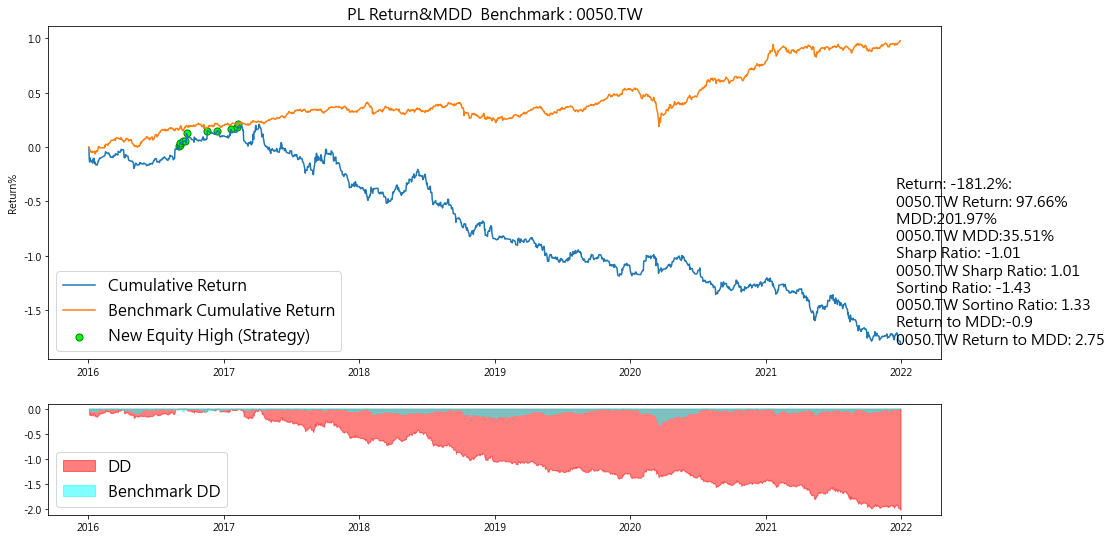

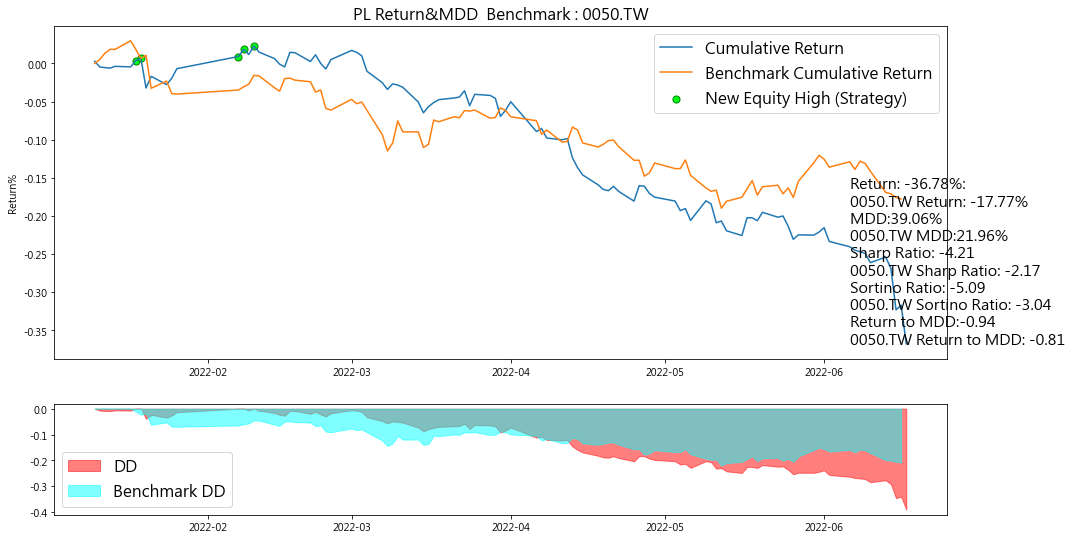

In [135]:
for i in [train_long_ret,test_long_ret] :
    equity_plot(pd.DataFrame([i]).T.fillna(0).cumsum(),'0050.TW','PL',1)

### 選股分布

In [136]:
train_target = pd.DataFrame(list(train_long_target.values())).melt(value_name = '股票代碼')
test_target = pd.DataFrame(list(test_long_target.values())).melt(value_name = '股票代碼')

In [137]:
industry = pd.read_pickle(path+'產業類別.pkl')
industry = industry.rename(columns = {'stock_id':'股票代碼'})

train_ind = train_target.merge(industry,  on = ['股票代碼'])
test_ind = test_target.merge(industry,  on = ['股票代碼'])

<AxesSubplot:ylabel='產業類別'>

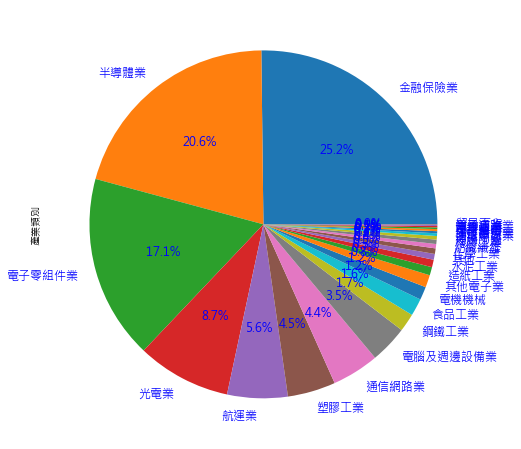

In [142]:
train_ind[['股票代碼','產業類別']].產業類別.value_counts().plot(kind = 'pie',figsize = (20,8),
                                               fontsize = 12,textprops={'color':"b"},
                                               rot=0, autopct='%1.1f%%')

<AxesSubplot:ylabel='產業類別'>

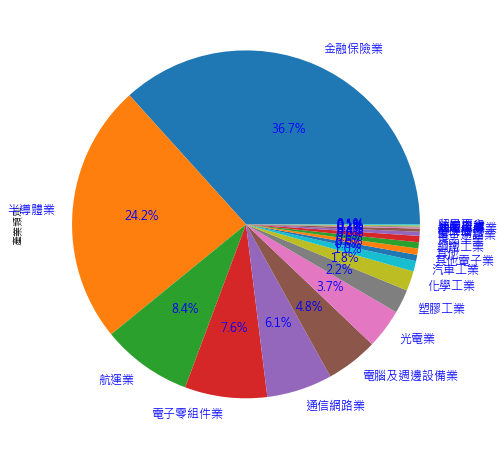

In [141]:
test_ind[['股票代碼','產業類別']].產業類別.value_counts().plot(kind = 'pie',figsize = (20,8),
                                               fontsize = 12,textprops={'color':"b"},
                                               rot=0, autopct='%1.1f%%')

### Function

In [38]:
def signal(df,date,direction,prob,prob_df,time_df,volume_df) :
    
    if direction == '-' :
        stock = df.loc[time_df[date]][df.loc[time_df[date]] == -1].index
    if direction == '+' :
        stock = df.loc[time_df[date]][df.loc[time_df[date]] == 1].index
    
    prob = prob_df.loc[time_df[date]][prob_df.loc[time_df[date]] >= prob].index
    volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 10000000].index
#     vol = vol_df.loc[time_df[date]][vol_df.loc[time_df[date]] >= 2].index
    
#     volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 0].index
    
    return sorted(set(stock)&set(prob)&set(volume))

In [39]:
def weight_return(stock,prob_df,intra_df,time_df,day,fee) :
    if len(stock) == 0 :
        return -fee

    prob_sum = prob_df.loc[time_df[day],stock].sum()
    if prob_sum == 0 :
        return -fee

    weight = prob_df.loc[time_df[day],stock]/prob_sum
    weight_return = intra_df.loc[time_df[day],stock]*weight
    weight_return = weight_return.sum() - fee
    return weight_return